In [62]:
# ==============
# IMPORTS
# ==============

import pandas as pd
from sklearn.linear_model import LogisticRegression
import numpy as np
import matplotlib.pyplot as plt

In [63]:
# ==============
# MAIN CONFIG
# ==============

PREDICTOR1 = 'voicing'                    # first predictor column name
PREDICTOR2 = 'duration'                   # second predictor column name
FILENAME_COL = 'filename'                 # filename column name
LABEL_MAPPING = {'s': 0, 'z': 1}          # binary output label mapping

TARGET = 'answer_batch'                   # target column name
DATA_PATH = 'data/data.csv'               # sound info data file path
PARTICIPANT_CSV_DIR = 'data/participants' # participant CSV directory
PROCESSED_PATH = 'data_processed.csv'     # processed data file path; leave blank to disable

INIT_RANDOM_SAMPLES = 10                  # initial random samples to collect
MIN_ITERATIONS = 30                       # minimum number of iterations
CLEANSER_FREQUENCY = 0                    # insert a high-certainty sample every nth iteration to prevent participant fatigue (irrelevant for virtual agents); 0 to disable
MODEL_CERTAINTY_CUTOFF = 0.95             # stopping certainty threshold
PARTICIPANT_TO_MODEL = 'p03'              # participant ID to simulate

In [64]:
# ==============
# HUMAN PARTICIPANT FUNCTIONS
# ==============

def query_real_class(filename):
    """
    Queries a participant for a classification of a given sample
    """

In [65]:
# ==============
# VIRTUAL AGENT FUNCTIONS
# ==============

def query_real_class(filename):
    """
    Queries a virtual agent for a classification of a given sample
    """
    # look into the participant's answer lookup table - PARTICIPANT_CSV_DIR/PARTICIPANT_TO_MODEL.csv
    # return the real class based on LABEL_MAPPING
    participant_answers = pd.read_csv(PARTICIPANT_CSV_DIR + '/' + PARTICIPANT_TO_MODEL + '.csv')
    real_answer = participant_answers[participant_answers[FILENAME_COL] == filename][TARGET].values[0]
    return LABEL_MAPPING[real_answer]

In [ ]:
# ==============
# SHARED FUNCTIONS
# ==============

# create stimuli dataframe
stimuli = pd.read_csv(DATA_PATH)

# add columns for classification order, classification type, real class, predicted class, and prediction certainty
stimuli['classification_order'] = None
stimuli['classification_type'] = None
stimuli['real_class'] = None
stimuli['predicted_class'] = None
stimuli['prediction_certainty'] = None

def train_model():
    """
    Trains a logistic regression model based on the current state of the stimuli dataframe.
    Updates predicted_class and prediction_certainty for unlabeled samples.
    """

    # filter to only labeled samples
    valid = stimuli['real_class'].isin([0, 1])
    if valid.sum() < 2:
        raise ValueError("Not enough labeled samples to train the model.")

    # features and labels
    X_train = stimuli.loc[valid, [PREDICTOR1, PREDICTOR2]]
    y_train = stimuli.loc[valid, 'real_class'].astype(int)

    # define and train logistic regression model
    model = LogisticRegression(max_iter=1000)
    model.fit(X_train, y_train)

    # apply model to unlabeled data
    unknown = stimuli['real_class'].isna()
    if unknown.sum() == 0:
        print("No unknown samples to predict.")
        return model

    X_test = stimuli.loc[unknown, [PREDICTOR1, PREDICTOR2]]
    probs = model.predict_proba(X_test)

    # predicted class (0 or 1) and associated certainty
    predicted = model.predict(X_test)
    certainty = probs.max(axis=1)

    # store predictions in dataframe
    stimuli.loc[unknown, 'predicted_class'] = predicted
    stimuli.loc[unknown, 'prediction_certainty'] = certainty

    return model

def plot_results(answered_data, unanswered_data, model):
    """Visualize results with decision boundary and improved legend/color bar"""
    
    plt.figure(figsize=(10, 6), dpi=300)
    
    # convert answers to numeric if necessary
    if answered_data['real_class'].dtype == 'object':
        answered_data = answered_data.copy()
        answered_data['real_class'] = answered_data['real_class'].astype(int)
        
    # plot answered points, split by class
    for label_char, label_num in LABEL_MAPPING.items():
        subset = answered_data[answered_data['real_class'] == label_num]
        if not subset.empty:
            plt.scatter(
                subset[PREDICTOR1],
                subset[PREDICTOR2],
                c='blue' if label_num == 0 else 'red',
                label=f"answered ({label_char})",
                edgecolors='k'
            )

    # plot unanswered points
    if not unanswered_data.empty:
        plt.scatter(
            unanswered_data[PREDICTOR1], 
            unanswered_data[PREDICTOR2],
            c='gray',
            alpha=0.5,
            label='unanswered'
        )
    
    # decision boundary grid
    x_min, x_max = stimuli[PREDICTOR1].min() - 1, stimuli[PREDICTOR1].max() + 1
    y_min, y_max = stimuli[PREDICTOR2].min() - 1, stimuli[PREDICTOR2].max() + 1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                         np.linspace(y_min, y_max, 100))
    
    grid_points = pd.DataFrame(
        np.c_[xx.ravel(), yy.ravel()],
        columns=[PREDICTOR1, PREDICTOR2]
    )
    
    Z = model.predict_proba(grid_points)[:, 1]
    Z = Z.reshape(xx.shape)
    
    # show background decision gradient
    contour = plt.contourf(xx, yy, Z, alpha=0.3, levels=20, cmap='coolwarm')
    
    # custom color bar with labels s and z
    cbar = plt.colorbar(contour, ticks=[0, 1])
    rev_label_map = {v: k for k, v in LABEL_MAPPING.items()}
    cbar.ax.set_yticklabels([rev_label_map[0], rev_label_map[1]])
    cbar.set_label('predicted answer')
    
    plt.xlabel(PREDICTOR1)
    plt.ylabel(PREDICTOR2)
    plt.title(f'Virtual Agent Results (participant: {PARTICIPANT_TO_MODEL})')
    plt.legend()
    plt.tight_layout()
    plt.show()

Iteration 1: Random sample.
Iteration 2: Random sample.
Iteration 3: Random sample.
Iteration 4: Random sample.
Iteration 5: Random sample.
Iteration 6: Random sample.
Iteration 7: Random sample.
Iteration 8: Random sample.
Iteration 9: Random sample.
Iteration 10: Random sample.
Iteration 11: Random sample.
Iteration 12: Random sample.
Iteration 13: Random sample.
Iteration 14: Random sample.
Iteration 15: Random sample.


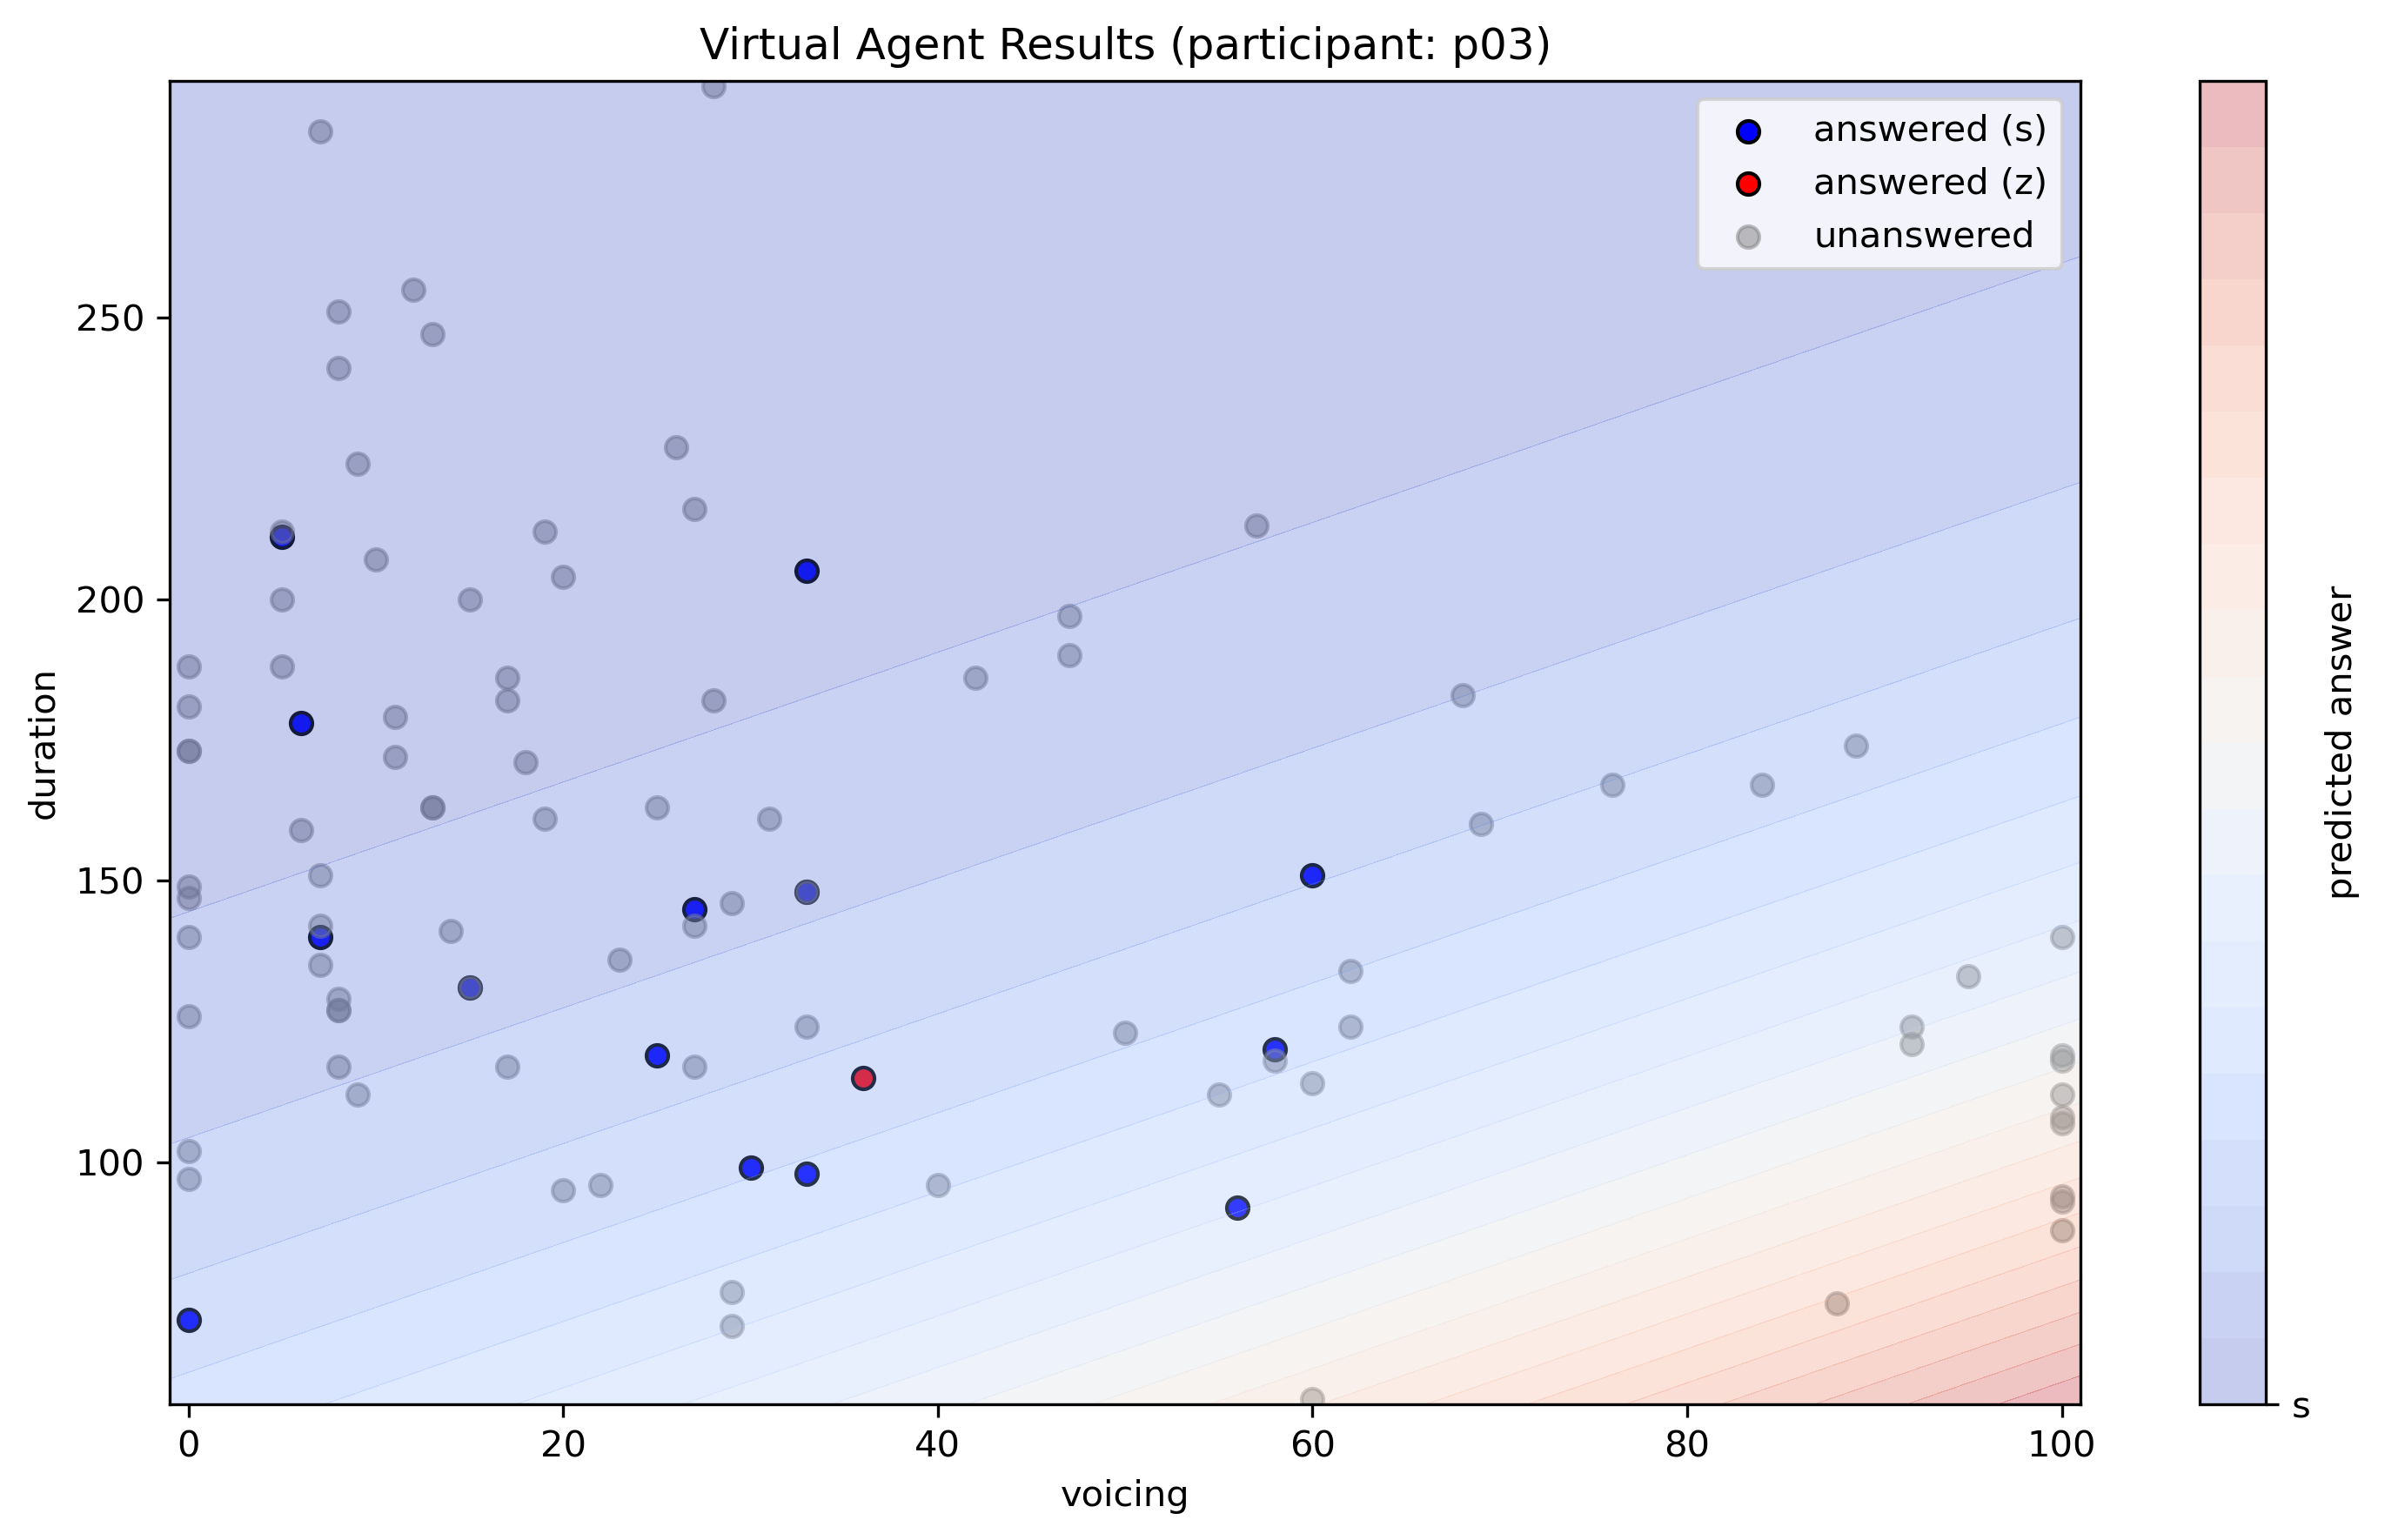

Processed data saved to data_processed.csv


In [ ]:
# ==============
# MAIN EXECUTION
# ==============

# initial random sampling with class balance
collected_classes = set()

iteration = 1
while iteration <= INIT_RANDOM_SAMPLES or len(collected_classes) < 2:
    print(f"Iteration {iteration}: Random sample.")

    # select a random stimulus where real class is unknown
    sample = stimuli[stimuli['real_class'].isna()].sample(1)

    # get classification, querying filename
    classification = int(query_real_class(sample[FILENAME_COL].values[0]))
    
    collected_classes.add(classification)

    # update row in dataframe
    idx = stimuli[FILENAME_COL] == sample[FILENAME_COL].values[0]
    stimuli.loc[idx, 'classification_order'] = iteration
    stimuli.loc[idx, 'classification_type'] = 'random'
    stimuli.loc[idx, 'real_class'] = classification

    iteration += 1

# train initial model
model = train_model()

# split answered and unanswered data
answered = stimuli[stimuli['real_class'].notna()]
unanswered = stimuli[stimuli['real_class'].isna()]

# plot the results
plot_results(answered, unanswered, model)

# save dataframe
if PROCESSED_PATH:
    stimuli.to_csv(PROCESSED_PATH, index = False)
    print(f"Processed data saved to {PROCESSED_PATH}")
else:
    print("Processed data not saved - PROCESSED_PATH is empty")
